# Projeto Final do Bootcamp LAMIA

## Esse projeto é de autoria de: Guilherme Loan Schneider

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
%pip install roboflow torch
%pip install ultralytics

In [ ]:
%pip install torch

In [ ]:
%pip install roboflow

In [2]:
from roboflow import Roboflow

In [2]:
# Baixando o modelo do Yolov11 small
from ultralytics import YOLO
model = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:00<00:00, 23.8MB/s]


### Base de região de interesse (ROI)

In [1]:
# https://universe.roboflow.com/tugas-akhir-taaag/vin-good
from roboflow import Roboflow
rf = Roboflow(api_key="0loMwrWJPTNZUN1c2TEP")
project = rf.workspace("tugas-akhir-taaag").project("vin-good")
version = project.version(13)
VIN_completo = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


### Bases de cada caracter individual

In [3]:
# https://universe.roboflow.com/tugas-akhir-taaag/vin-2
rf = Roboflow(api_key="t71kG0dstvTXQmTEnHSH")
project = rf.workspace("tugas-akhir-taaag").project("vin-2")
version = project.version(5)
VIN_chars = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to VIN-2-5 in yolov11:: 100%|██████████| 1882/1882 [00:35<00:00, 52.88it/s]


In [ ]:
# https://universe.roboflow.com/rafi-akbar-9hduc/tugas-akhir-hmrtn/dataset/2
# from roboflow import Roboflow
# rf = Roboflow(api_key="0loMwrWJPTNZUN1c2TEP")
# project = rf.workspace("rafi-akbar-9hduc").project("tugas-akhir-hmrtn")
# version = project.version(2)
# dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tugas-Akhir-2 in yolov11:: 100%|██████████| 1730/1730 [00:41<00:00, 41.93it/s]


In [4]:
# https://universe.roboflow.com/personal-sspf3/vin-tngcp-lmfcr/dataset/2#
from roboflow import Roboflow
rf = Roboflow(api_key="0loMwrWJPTNZUN1c2TEP")
project = rf.workspace("personal-sspf3").project("vin-tngcp-lmfcr")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to VIN-2 in yolov11:: 100%|██████████| 4512/4512 [02:22<00:00, 31.67it/s] 


In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

# Filtrando os dados para apenas com imagens que contenham 17 caracteres

In [ ]:
import os
import shutil

bases = {
    "VIN-2": "./VIN-2",
    "VIN-2-5": "./VIN-2-5",
}
output_base = "./merged_dataset_converted"
splits = ['train', 'valid', 'test']

def merge_datasets():
    for split in splits:
        img_dst = os.path.join(output_base, split, "images")
        lbl_dst = os.path.join(output_base, split, "labels")
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(lbl_dst, exist_ok=True)

        for base_name, base_path in bases.items():
            img_src = os.path.join(base_path, split, "images")
            lbl_src = os.path.join(base_path, split, "labels")

            if not (os.path.isdir(img_src) and os.path.isdir(lbl_src)):
                continue

            for fname in os.listdir(img_src):
                if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                label_file = os.path.splitext(fname)[0] + ".txt"
                label_path = os.path.join(lbl_src, label_file)

                if not os.path.isfile(label_path):
                    continue
                with open(label_path, "r") as f:
                    lines = f.readlines()
                if len(lines) != 17:
                    continue

                # Copia os arquivos com prefixo indicando a base
                new_img = f"{base_name}_{fname}"
                new_lbl = f"{base_name}_{os.path.splitext(fname)[0]}.txt"
                shutil.copy2(os.path.join(img_src, fname), os.path.join(img_dst, new_img))
                shutil.copy2(label_path, os.path.join(lbl_dst, new_lbl))

merge_datasets()

# Parte de correção dos datasets, junção e separação em conjunto de treino, teste e validação

In [ ]:
import os

final_classes = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','J','K',
    'L','M','N','P','R','S','T','U','V','W',
    'X','Y','Z'
]

# Dataset 1 original (37 classes)
classes_37 = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','I','J',
    'K','L','M','N','NORANG','NOSIN','O','P',
    'R','S','T','U','V','W','X','Y','Z'
]

# Dataset 2 original (35 classes)
classes_35 = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','I','J',
    'K','L','M','N','O','P','R','S','T','U',
    'V','W','X','Y','Z'
]

def build_class_map(old_classes):
    """Cria o mapeamento old_index -> new_index ou None (se deve ser removida)"""
    mapping = {}
    for idx, c in enumerate(old_classes):
        if c not in final_classes:
            mapping[idx] = None  # descartar
        else:
            mapping[idx] = final_classes.index(c)
    return mapping

map_37 = build_class_map(classes_37)
map_35 = build_class_map(classes_35)

print("Mapeamento dataset 37:", map_37)
print("Mapeamento dataset 35:", map_35)

# Corrigir os arquivos de labels
def fix_labels(dataset_path, mapping):
    splits = ['train', 'valid', 'test']
    for split in splits:
        lbl_dir = os.path.join(dataset_path, split, "labels")
        for fname in os.listdir(lbl_dir):
            if not fname.endswith(".txt"):
                continue

            fpath = os.path.join(lbl_dir, fname)
            new_lines = []
            with open(fpath, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue

                    old_cls = int(parts[0])
                    new_cls = mapping[old_cls]

                    if new_cls is None:
                        continue

                    parts[0] = str(new_cls)
                    new_lines.append(" ".join(parts))

            with open(fpath, "w") as f:
                f.write("\n".join(new_lines))

fix_labels("./VIN-2-5", map_35)

Mapeamento dataset 37: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: None, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: None, 25: None, 26: None, 27: 23, 28: 24, 29: 25, 30: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32}
Mapeamento dataset 35: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: None, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: None, 25: 23, 26: 24, 27: 25, 28: 26, 29: 27, 30: 28, 31: 29, 32: 30, 33: 31, 34: 32}


In [ ]:
import os
import shutil
import random

bases = {
    "VIN-2": "./VIN-2",
    "VIN-2-5": "./VIN-2-5",
}
output_base = "./merged_dataset_converted"
splits = ['train', 'valid', 'test']

# proporções
train_ratio = 0.65
test_ratio = 0.25
valid_ratio = 0.10

def merge_and_split():
    all_files = []

    # Coleta todos os pares (imagem, label) das bases
    for base_name, base_path in bases.items():
        for split in ['train', 'valid', 'test']:  # lê de qualquer split
            img_src = os.path.join(base_path, split, "images")
            lbl_src = os.path.join(base_path, split, "labels")

            if not (os.path.isdir(img_src) and os.path.isdir(lbl_src)):
                continue

            for fname in os.listdir(img_src):
                if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                label_file = os.path.splitext(fname)[0] + ".txt"
                label_path = os.path.join(lbl_src, label_file)

                if not os.path.isfile(label_path):
                    continue

                with open(label_path, "r") as f:
                    lines = f.readlines()
                if len(lines) != 17:
                    continue

                all_files.append((base_name, fname, label_file, img_src, lbl_src))

    # Embaralha para aleatorizar
    random.shuffle(all_files)

    n_total = len(all_files)
    n_train = int(n_total * train_ratio)
    n_test = int(n_total * test_ratio)
    n_valid = n_total - n_train - n_test

    train_files = all_files[:n_train]
    test_files = all_files[n_train:n_train+n_test]
    valid_files = all_files[n_train+n_test:]

    split_map = {
        'train': train_files,
        'test': test_files,
        'valid': valid_files
    }

    # Cria pastas e copia
    for split, files in split_map.items():
        img_dst = os.path.join(output_base, split, "images")
        lbl_dst = os.path.join(output_base, split, "labels")
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(lbl_dst, exist_ok=True)

        for base_name, img_name, lbl_name, img_src, lbl_src in files:
            new_img = f"{base_name}_{img_name}"
            new_lbl = f"{base_name}_{os.path.splitext(img_name)[0]}.txt"
            shutil.copy2(os.path.join(img_src, img_name), os.path.join(img_dst, new_img))
            shutil.copy2(os.path.join(lbl_src, lbl_name), os.path.join(lbl_dst, new_lbl))

    print(f"Total: {n_total} | Train: {n_train} | Test: {n_test} | Valid: {n_valid}")

merge_and_split()


Total: 1333 | Train: 866 | Test: 333 | Valid: 134


# Realizando o data augmentation no dataset dos VINs (apenas modelo do ROI)

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Caminhos
yaml_path = "merged_dataset_norang/data.yaml"
base_dir = os.path.dirname(yaml_path)

input_images = os.path.join(base_dir, "train/images")
input_labels = os.path.join(base_dir, "train/labels")

output_images = os.path.join(base_dir, "train/images_aug")
output_labels = os.path.join(base_dir, "train/labels_aug")

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

N_AUGS = 3  # Número de augmentações por imagem

# Augmentations sutis
augment = A.Compose([
    A.Affine(
        scale=(0.95, 1.05),
        translate_percent=(0.02, 0.02),
        rotate=(-3, 3),
        p=0.7
    ),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),
        A.MotionBlur(blur_limit=(3, 5), p=0.5),
    ], p=0.3),
    A.OneOf([
        A.ImageCompression(quality_range=(60, 95), p=0.5),
        A.GaussNoise(var_limit=(10.0, 30.0), p=0.5),
    ], p=0.3),
    A.CLAHE(clip_limit=(1, 3), tile_grid_size=(8, 8), p=0.2)
], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"], clip=True))

# Função para ler labels YOLO
def read_labels(label_path):
    bboxes, labels = [], []
    if not os.path.exists(label_path):
        return bboxes, labels
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            bboxes.append([x, y, w, h])
            labels.append(int(cls))
    return bboxes, labels

# Função para clipar bboxes para [0, 1]
def clip_bbox(bbox):
    # YOLO: [x_center, y_center, width, height]
    x, y, w, h = bbox
    x = min(max(x, 0.0), 1.0)
    y = min(max(y, 0.0), 1.0)
    w = min(max(w, 0.0), 1.0)
    h = min(max(h, 0.0), 1.0)
    return [x, y, w, h]

# Função para salvar labels YOLO
def save_labels(label_path, bboxes, labels):
    with open(label_path, "w") as f:
        for bbox, cls in zip(bboxes, labels):
            clipped_bbox = clip_bbox(bbox)
            f.write(f"{cls} {clipped_bbox[0]} {clipped_bbox[1]} {clipped_bbox[2]} {clipped_bbox[3]}\n")

# Loop pelas imagens
for fname in tqdm(os.listdir(input_images)):
    if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
        continue
    
    img_path = os.path.join(input_images, fname)
    label_path = os.path.join(input_labels, os.path.splitext(fname)[0] + ".txt")
    
    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    
    bboxes, labels = read_labels(label_path)
    
    if not bboxes:
        continue
    
    for i in range(N_AUGS):
        augmented = augment(image=image, bboxes=bboxes, class_labels=labels)
        aug_img = augmented["image"]
        aug_bboxes = augmented["bboxes"]
        aug_labels = augmented["class_labels"]

        # Clipa bboxes para [0, 1]
        aug_bboxes = [clip_bbox(bbox) for bbox in aug_bboxes]

        out_img_path = os.path.join(output_images, f"aug{i}_{fname}")
        cv2.imwrite(out_img_path, aug_img)

        out_lbl_path = os.path.join(output_labels, f"aug{i}_{os.path.splitext(fname)[0]}.txt")
        save_labels(out_lbl_path, aug_bboxes, aug_labels)

print("Data augmentation salvo em:", output_images)


# Aplica o pré-processamento no dataset inteiro

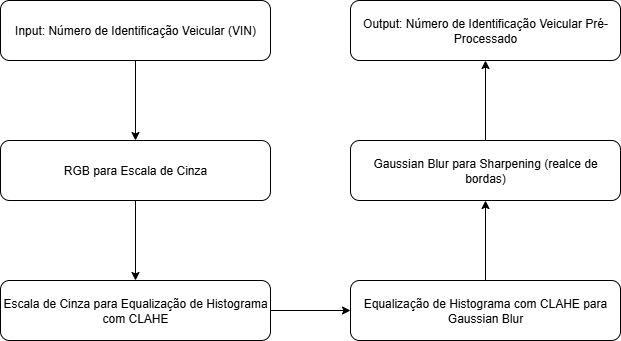

In [ ]:
import os
import cv2
import numpy as np
import shutil
from tqdm import tqdm

# --- Função de pré-processamento ---
def preprocess_full_image(image):
    # Converter para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Suavização
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)

    final_img = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)
    return final_img

# --- Caminhos de entrada e saída ---
input_dataset = "./merged_dataset_norang"
output_dataset = "./merged_dataset_norang_preprocessed"

splits = ["train", "valid", "test"]

# --- Criação da estrutura do novo dataset ---
for split in splits:
    os.makedirs(os.path.join(output_dataset, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dataset, split, "labels"), exist_ok=True)

# --- Aplicação do pré-processamento ---
for split in splits:
    input_img_dir = os.path.join(input_dataset, split, "images")
    input_lbl_dir = os.path.join(input_dataset, split, "labels")
    output_img_dir = os.path.join(output_dataset, split, "images")
    output_lbl_dir = os.path.join(output_dataset, split, "labels")

    img_files = [f for f in os.listdir(input_img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    print(f"\nProcessando conjunto: {split} ({len(img_files)} imagens)")

    for img_name in tqdm(img_files, desc=f"Pré-processando {split}"):
        img_path = os.path.join(input_img_dir, img_name)
        out_img_path = os.path.join(output_img_dir, img_name)

        # Aplicar o pré-processamento
        image = cv2.imread(img_path)
        if image is None:
            print(f"Erro ao ler {img_path}")
            continue

        processed = preprocess_full_image(image)
        cv2.imwrite(out_img_path, processed)

        # Copiar label correspondente
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_src = os.path.join(input_lbl_dir, label_name)
        label_dst = os.path.join(output_lbl_dir, label_name)

        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)

print(f"{output_dataset}")

# Analisando o .txt das labels para ver se estão corretos

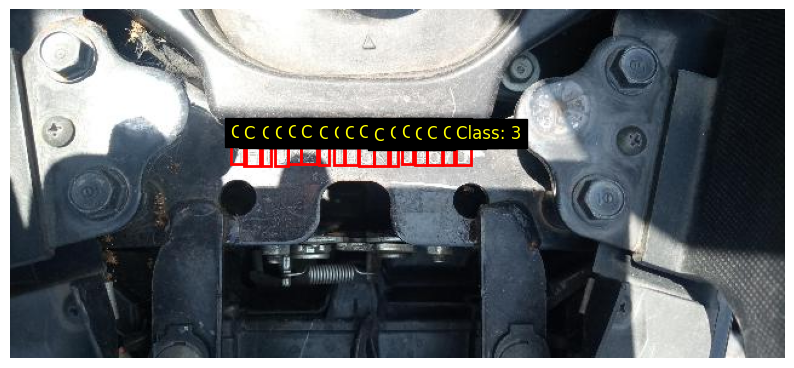

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_image_with_labels(img_path, label_path):
    # Carrega a imagem
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]

    # Lê as labels no formato YOLO: class x_center y_center width height
    boxes = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, bw, bh = map(float, parts)
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            boxes.append((x1, y1, x2, y2, int(cls)))

    # Plota imagem e boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()
    for x1, y1, x2, y2, cls in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"Class: {cls}", color='yellow', fontsize=12, backgroundcolor='black')
    plt.axis('off')
    plt.show()

plot_image_with_labels("./merged_dataset_converted/train/images/VIN-2-5_D6621SAY-NO-RANGKA_jpg.rf.58de7a8b5a7c07e1104682d084b21341.jpg"
                       , "./merged_dataset_converted/train/labels/VIN-2-5_D6621SAY-NO-RANGKA_jpg.rf.58de7a8b5a7c07e1104682d084b21341.txt")


# Realizando o treinamento do ROI

In [ ]:
from ultralytics import YOLO

# Caminho para o YAML do dataset de ROI
data_roi_yaml = 'merged_dataset_norang_preprocessed/data.yaml'

# Carrega o modelo YOLOv11 base
model_roi = YOLO('yolo11s.pt')

# Treinamento
model_roi.train(
    data=data_roi_yaml,
    epochs=35,
    imgsz=640,
    batch=16,
    workers=4,
    name='vin_roi_detection_preprocessed_dataset',
    augment=True
)

# Avaliação
metrics = model_roi.val()
print(metrics)

In [ ]:
# Carregando o modelo treinado para verificar as métricas
from ultralytics import YOLO
model = YOLO('./models_acc/detect/vin_roi_detection_augmented_27epochs/weights/best.pt')  # modelo YOLO para detectar VIN
# Verificando as métricas
metrics = model.val()
print(metrics)

# Testando os resultados do treino com uma imagem

In [ ]:
from ultralytics import YOLO
model = YOLO('./runs/detect/vin_roi_detection6/weights/best.pt')
results = model.predict(
    source='./merged_dataset_converted/train/images/VIN-2_D3592SAA-NO-RANGKA_jpg.rf.b0ac1bf212c2f676fbfb03c41ea5eef6.jpg',
    conf=0.5,
    save=True,
    save_txt=True,
    device=0
)

# Realizando o treinamento de cada caracter

### Utilizando o dataset convertido (Adaptação das labels que não estavam padronizadas (37 em um e 35 no outro))

In [ ]:
from ultralytics import YOLO
# Caminho para o YAML do dataset de caracteres
data_chars_yaml = './merged_dataset_converted/data.yaml'

# Novo modelo YOLO para detectar caracteres
model_chars = YOLO('yolo11s.pt')

# Treinamento
model_chars.train(
    data=data_chars_yaml,
    epochs=80,
    imgsz=640,
    batch=16,
    name='vin_char_detection_chars_yolo11s'
)

# Avaliação'
# metrics = model_chars.val()
# print(metrics)

In [ ]:
from ultralytics import YOLO
model = YOLO('./runs/detect/vin_char_detection_vin-2-5/weights/best.pt')
results = model.predict(
    source='VIN-(Good)-13/train/images/',
    conf=0.5,
    save=True,
    save_txt=True,
    device=0
)

metrics = model.val()
print(metrics)

In [12]:
# Carregando o modelo treinado para verificar as métricas
from ultralytics import YOLO
model = YOLO('./runs/detect/vin_char_detection_chars_yolo11s/weights/best.pt')
# Verificando as métricas
metrics = model.val()
print(metrics)

Ultralytics 8.3.140  Python-3.12.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8187MiB)
YOLO11s summary (fused): 100 layers, 9,425,571 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 1.80.4 ms, read: 5.14.4 MB/s, size: 104.5 KB)


val: Scanning G:\Meu Drive\UTFPR\7o Período\Tcc 1\Códigos\merged_dataset_converted\valid\labels... 134 images, 0 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:03<00:00, 42.46it/s]


val: New cache created: G:\Meu Drive\UTFPR\7o Perodo\Tcc 1\Cdigos\merged_dataset_converted\valid\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


                   all        134       2278      0.951      0.894      0.955      0.708
                     0         97        180      0.959      0.909      0.961      0.711
                     1        117        354      0.978      0.878      0.951      0.625
                     2         89        145      0.982      0.938      0.988      0.761
                     3         82        132      0.974      0.854       0.96      0.714
                     4         79        113      0.979       0.92       0.97      0.687
                     5         70         97      0.992      0.897       0.97      0.751
                     6         75        104      0.967      0.923      0.959      0.675
                     7         67         82      0.974       0.91      0.968      0.695
                     8         72        103      0.979      0.891      0.967      0.728
                     9         71         95      0.968      0.884      0.962      0.696
                     

# Aplicando o pipeline completo e Realizando as inferências

In [ ]:
import cv2
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO
import torch
import torchvision.ops as ops

# Paths
ROI_MODEL_PATH = './models_acc/detect/vin_roi_detection_augmented_27epochs/weights/best.pt'  # modelo YOLO para detectar VIN
CLASSIFIER_MODEL_PATH = 'vin_char_classifier+augmentation_2.pth'  # modelo ResNet treinado no outro código
_original_listdir = os.listdir  # guardar função original

CLASSES_LIST = [str(i) for i in range(10)] + \
               [chr(c) for c in range(ord('A'), ord('Z')+1) if chr(c) not in ('I', 'O', 'Q')]

# Caminho "virtual" usado apenas para manter compatibilidade
CLASSES_PATH = 'VIN_CLASSES_IN_CODE'

def _listdir_override(path):
    if path == CLASSES_PATH:
        return CLASSES_LIST.copy()
    return _original_listdir(path)

# Sobrescreve temporariamente os.listdir para retornar nossa lista quando solicitado CLASSES_PATH
os.listdir = _listdir_override

# Transformação para classificador
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar classificador
from torchvision import models
classifier = models.resnet18(pretrained=False)
classifier.fc = torch.nn.Linear(classifier.fc.in_features, len(os.listdir(CLASSES_PATH)))
classifier.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH, map_location=device))
classifier.to(device)
classifier.eval()

char_classes = sorted(os.listdir(CLASSES_PATH))

# Carregar detector de ROI
detector = YOLO(ROI_MODEL_PATH)

def refine_vin_predictions(boxes, class_names, image_width, max_chars=17, iou_thresh=0.6):
    """
    Refina as detecções dos caracteres:
    - Remove sobreposições via NMS (IoU)
    - Ordena da esquerda para a direita
    - Retorna VIN com no máximo 17 caracteres
    
    Args:
        boxes (ultralytics.results.Boxes): caixas preditas pelo YOLO
        class_names (dict): dicionário {id: label},
        image_width (int): largura da imagem para checagens
        max_chars (int): máximo de caracteres no VIN (default: 17)
        iou_thresh (float): limiar para filtrar sobreposição (default: 0.6)
    
    Returns:
        vin_string (str): VIN final com no máximo 17 caracteres
    """
    if len(boxes) == 0:
        return ""

    # Convert boxes para tensores (formato xyxy)
    box_coords = torch.stack([b.xyxy[0] for b in boxes])
    scores = torch.tensor([b.conf[0].item() for b in boxes])

    # NMS para remover sobreposição
    keep = ops.nms(box_coords, scores, iou_threshold=iou_thresh)
    filtered_boxes = [boxes[i] for i in keep]

    # Agrupar: (x_position, predicted_char, confidence)
    char_preds = []
    for b in filtered_boxes:
        cls_id = int(b.cls.item())
        conf = float(b.conf.item())
        label = class_names.get(cls_id, '?')
        x_center = (b.xyxy[0][0] + b.xyxy[0][2]) / 2  # centro x
        char_preds.append((x_center.item(), label, conf))

    # Ordenar da esquerda para a direita e por confiança (em caso de empate de posição)
    char_preds = sorted(char_preds, key=lambda x: (x[0], -x[2]))

    # Pegar no máximo os N mais confiáveis da esquerda para a direita
    vin_chars = [char for _, char, _ in char_preds[:max_chars]]

    # Juntar os caracteres
    vin_string = ''.join(vin_chars)

    return vin_string

def preprocess_full_image(image, debug=True, save_path="debug_full_preproc.jpg"):
    """
    Pré-processamento aplicado na imagem inteira (ROI do VIN):
    - Conversão para cinza
    - CLAHE (equalização adaptativa de histograma)
    - Suavização leve (GaussianBlur)
    - Sharpen (realce de bordas)
    """
    # Escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE (melhora contraste localmente)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Suavização leve (Gaussian)
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Sharpening (realce de bordas)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)

    # Converter para 3 canais novamente (para compatibilidade com redes)
    final_img = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)

    # Debug: salvar estágios lado a lado
    if debug:
        stacked = np.hstack([
            cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR),
            cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR),
            cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR),
            final_img
        ])
        cv2.imwrite(save_path, stacked)
        print(f"Pré-processamento salvo em {save_path}")

    return final_img

# Rotação automática baseada em OCR
def correct_orientation(image, roi_model):
    """
    Corrige a orientação da imagem usando o modelo YOLO de ROI (VIN).
    """
    for angle in [0, 90, 180, 270]:
        # Rotacionar a imagem
        rotated = cv2.rotate(image, {
            0: None,
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle]) if angle != 0 else image

        results = roi_model(rotated)[0]

        if not results.boxes:
            continue  # sem ROI detectada

        x1, y1, x2, y2 = map(int, results.boxes[0].xyxy[0])
        width, height = x2 - x1, y2 - y1

        # Critério simples: se estiver "em pé", rotaciona
        if width > height:
            return rotated, results  # imagem já está orientada corretamente
        # Senão, continua tentando outro ângulo

    return image, None  # fallback se nenhuma caixa correta for detectada

# Pipeline completo
def process_image(image_path):
    print(f"\nProcessando: {image_path}")

    image = cv2.imread(image_path)
    image_oriented, roi_result = correct_orientation(image, detector)

    # Usar a primeira bounding box da ROI detectada
    if not roi_result or not roi_result.boxes:
        print("Nenhuma ROI detectada após correção.")
        return

    x1, y1, x2, y2 = map(int, roi_result.boxes[0].xyxy[0])
    vin_roi = image_oriented[y1:y2, x1:x2]
    
    vin_roi = preprocess_full_image(vin_roi, debug=True)
    
    if vin_roi.size == 0:
        print("Recorte ROI vazio.")
        return

    # (Opcional) Salvar ou visualizar o VIN recortado
    cv2.imwrite("vin_roi.jpg", vin_roi)

    # Processar cada caractere individualmente
    vin_chars = detect_and_classify_characters_resnet(vin_roi) 
    # !! Existem dois modelos aqui, um com a ResNet18 e outro sem !!
    # Para trocar o modelo, use detect_and_classify_characters(vin_roi) para o modelo sem ResNet18 e
    # detect_and_classify_characters_resnet(vin_roi) para o modelo com ResNet18.
    vin_string = ''.join([char for _, char in vin_chars])

    print(f"VIN Detectado: {vin_string}")
    return vin_string

def detect_and_classify_characters(roi_image, max_chars=17, save_path="vin_characters_detected.jpg"):
    char_detector = YOLO("./models_acc/detect/vin_char_detection_yolo11s/weights/best.pt")
    results = char_detector(roi_image)[0]

    char_preds = []
    drawn_image = roi_image.copy()

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = roi_image[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        pil_img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = classifier(tensor)
            _, pred = torch.max(output, 1)
            char = char_classes[pred.item()]

        x_center = (x1 + x2) / 2
        conf = float(box.conf.item())
        char_preds.append((x_center, char, conf, (x1, y1, x2, y2)))

    # Ordenar da esquerda para a direita
    char_preds = sorted(char_preds, key=lambda x: x[0])

    # Se houver mais de 17 → pega os 17 mais confiáveis
    if len(char_preds) > max_chars:
        char_preds = sorted(char_preds, key=lambda x: (-x[2], x[0]))[:max_chars]
        char_preds = sorted(char_preds, key=lambda x: x[0])  # reordena

    # Se houver menos de 17 → preenche com '?'
    elif len(char_preds) < max_chars:
        char_preds.extend([(9999, '?', 0.0, (0,0,0,0))] * (max_chars - len(char_preds)))

    # --- Desenhar as boxes e classes na imagem ---
    for _, char, conf, (x1, y1, x2, y2) in char_preds:
        if (x1, y1, x2, y2) == (0,0,0,0):  # placeholder
            continue

        # Definir cor de acordo com a confiança
        if conf > 0.8:
            color = (0, 255, 0)     # Verde
        elif conf > 0.5:
            color = (0, 255, 255)   # Amarelo
        else:
            color = (0, 0, 255)     # Vermelho

        cv2.rectangle(drawn_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(drawn_image, f"{char} ({conf:.2f})", 
                    (x1, max(0, y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, color, 2)

    cv2.imwrite(save_path, drawn_image)
    print(f"Resultado salvo em {save_path}")

    return [(x, char) for x, char, _, _ in char_preds]

def detect_and_classify_characters_resnet(roi_image, max_chars=17, save_path="vin_characters_detected.jpg"):
    """
    Detecta caracteres do VIN usando YOLO e ResNet18.
    - YOLO fornece as detecções (boxes e classes)
    - ResNet18 refina a classificação de cada caractere
    - Se as predições coincidirem → mantém a classe
    - Se divergirem → escolhe o resultado com maior confiança
    """

    char_detector = YOLO("./models_acc/detect/vin_char_detection_yolo11s/weights/best.pt")
    results = char_detector(roi_image)[0]

    char_preds = []
    drawn_image = roi_image.copy()

    total_chars = 0
    divergences = 0
    resnet_corrections = 0

    for box in results.boxes:
        total_chars += 1
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = roi_image[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        # --- Predição YOLO ---
        yolo_cls_id = int(box.cls.item())
        yolo_char = char_classes[yolo_cls_id] if yolo_cls_id < len(char_classes) else '?'
        yolo_conf = float(box.conf.item())

        # --- Predição ResNet ---
        pil_img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        tensor = transform(pil_img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = classifier(tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            resnet_conf, resnet_pred = torch.max(probs, 1)
            resnet_char = char_classes[resnet_pred.item()]
            resnet_conf = resnet_conf.item()

        # --- Fusão de decisão ---
        if yolo_char == resnet_char:
            final_char = yolo_char
            final_conf = (yolo_conf + resnet_conf) / 2
        else:
            divergences += 1

            if resnet_conf > yolo_conf:
                final_char = resnet_char
                final_conf = resnet_conf
            else:
                final_char = yolo_char
                final_conf = yolo_conf

        x_center = (x1 + x2) / 2
        char_preds.append((x_center, final_char, final_conf, (x1, y1, x2, y2)))

    # --- Ordenar caracteres da esquerda para a direita ---
    char_preds = sorted(char_preds, key=lambda x: x[0])

    # --- Limitar a 17 caracteres mais confiáveis ---
    if len(char_preds) > max_chars:
        char_preds = sorted(char_preds, key=lambda x: (-x[2], x[0]))[:max_chars]
        char_preds = sorted(char_preds, key=lambda x: x[0])

    elif len(char_preds) < max_chars:
        char_preds.extend([(9999, '?', 0.0, (0, 0, 0, 0))] * (max_chars - len(char_preds)))

    # --- salvar imagem resultante ---
    for _, char, conf, (x1, y1, x2, y2) in char_preds:
        if (x1, y1, x2, y2) == (0, 0, 0, 0):
            continue
        cv2.rectangle(drawn_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(drawn_image, f"{char} ({conf:.2f})",
                    (x1, max(0, y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)

    cv2.imwrite(save_path, drawn_image)

    # --- Estatísticas de divergência ---
    if total_chars > 0:
        print("\n=== Comparação YOLO × ResNet18 ===")
        print(f"Total de caracteres detectados: {total_chars}")
        print(f"Divergências YOLO/ResNet: {divergences} ({divergences/total_chars*100:.1f}%)")
        print(f"Correções aplicadas pela ResNet: {resnet_corrections} ({resnet_corrections/total_chars*100:.1f}%)")
        print(f"Resultado salvo em {save_path}")

    return [(x, char) for x, char, _, _ in char_preds]

if __name__ == "__main__":
        process_image("./chassi.png")
        # process_image("./merged_dataset_converted/valid/images/VIN-2-5_D5163UCS_20NO_20RANGKA_jpg.rf.fac0cc9dc6775c04409ed39a4d1aec5a.jpg")


Processando: ./chassi5.png

0: 448x640 1 NORANG, 19.2ms
Speed: 3.2ms preprocess, 19.2ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)
Pré-processamento salvo em debug_full_preproc.jpg

0: 96x640 3 0s, 5 1s, 1 2, 1 3, 1 5, 1 9, 1 A, 1 C, 3 Es, 1 J, 1 T, 90.6ms
Speed: 0.6ms preprocess, 90.6ms inference, 2.2ms postprocess per image at shape (1, 3, 96, 640)

=== Comparação YOLO × ResNet18 ===
Total de caracteres detectados: 19
Divergências YOLO/ResNet: 7 (36.8%)
Correções aplicadas pela ResNet: 0 (0.0%)
Resultado salvo em vin_characters_detected.jpg
VIN Detectado: WCATT03401EEE1046


# Funções úteis

## Limpeza de datasets

In [ ]:
import os

# Caminhos do dataset
base_path = "./merged_dataset_converted/train"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

def sanitize_dataset(images_path, labels_path, delete=False):
    """
    Verifica inconsistências entre as pastas de imagens e labels.
    Se delete=True, remove arquivos sem correspondência.
    """
    # Lista de nomes sem extensão
    image_files = {os.path.splitext(f)[0] for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))}
    label_files = {os.path.splitext(f)[0] for f in os.listdir(labels_path) if f.lower().endswith('.txt')}

    # Diferenças
    images_without_labels = image_files - label_files
    labels_without_images = label_files - image_files

    print(f"Total de imagens: {len(image_files)}")
    print(f"Total de labels: {len(label_files)}")
    print(f"Imagens sem label: {len(images_without_labels)}")
    print(f"Labels sem imagem: {len(labels_without_images)}\n")

    if images_without_labels:
        print("Imagens sem labels correspondentes:")
        for f in sorted(images_without_labels):
            print(f"  - {f}")

    if labels_without_images:
        print("\nLabels sem imagens correspondentes:")
        for f in sorted(labels_without_images):
            print(f"  - {f}")

    # Excluir arquivos se delete=True
    if delete:
        print("\nExcluindo arquivos sem correspondência...")
        for f in images_without_labels:
            img_path = os.path.join(images_path, f + ".jpg")
            if not os.path.exists(img_path):
                img_path = os.path.join(images_path, f + ".png")
            if os.path.exists(img_path):
                os.remove(img_path)
                print(f"Removido: {img_path}")

        for f in labels_without_images:
            label_path = os.path.join(labels_path, f + ".txt")
            if os.path.exists(label_path):
                os.remove(label_path)
                print(f"Removido: {label_path}")

        print("\nLimpeza concluída.")

    return images_without_labels, labels_without_images

sanitize_dataset(images_path, labels_path, delete=False)

🔍 Total de imagens: 851
🔍 Total de labels: 851
⚠️ Imagens sem label: 0
⚠️ Labels sem imagem: 0



(set(), set())